In [1]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer
from src.acquisition.models.database_manager import DatabaseManager
from src.acquisition.models.db.database import db
from src.acquisition.models.db.database import initialize_db
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
from scipy import special


In [2]:
graph_names = ['Amiga CD32 games', 'Machine learning', 'Artificial intelligence', 'Game Boy games']

name  = graph_names[1]
db_name = 'wikipedia.db'
initialize_db(db_name)  
db_manager = DatabaseManager(db)

def get_unique_contributors_list_from_graph_name(graph_name):
    main_category_id = db_manager.get_main_category_by_name(graph_name)
    unique_contributors_per_article = db_manager.get_distinct_contributors_per_page(main_category_id)
    return list(unique_contributors_per_article.values())

def calculate_poisson_degree_distribution(degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        x = logarithmic_bins
        y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
        x = x[y > 0]
        y = y[y > 0]
        return x, y

def calculate_exponential_degree_distribution(degrees, logarithmic_bins):
        lamda = np.mean(degrees)
        beta = 1 / lamda
        x = logarithmic_bins
        y = beta * np.exp(-beta * x)
        # remove entries with 0 probability
        x = x[y > 0]
        y = y[y > 0]
        return x, y

def get_contributors_by_category_name(graph_name):
    main_category_id = db_manager.get_main_category_by_name(graph_name)
    return db_manager.get_all_contributors(main_category_id)

def get_number_of_co_contributors(graph_name, contributor_id):
    main_category_id = db_manager.get_main_category_by_name(graph_name)
    return len(db_manager.get_co_contributors(contributor_id,main_category_id))

def get_degree_by_graph_name(graph_name):
    contributors = get_contributors_by_category_name(name)    
    degrees = []
    for contributor in contributors:
        degree = get_number_of_co_contributors(graph_name, contributor)
        if degree > 0:
            degrees.append(degree)
    return degrees

Database initialized: wikipedia.db


In [20]:
def plot_probability_density(graph_names, only_fit_above=None):
        fig, axs = plt.subplots(2,2, figsize=(10,10))
        for i, name in enumerate(graph_names):
                unique_contributors = get_degree_by_graph_name(name)
                logarithmic_bins = np.logspace(np.log10(min(unique_contributors)), np.log10(max(unique_contributors)), num=20)
                hist_densitiy, bin_edges = np.histogram(unique_contributors, bins=logarithmic_bins, density=True)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Find the center of each bin
                #remove values with 0 probability
                bin_centers = bin_centers[hist_densitiy > 0]
                hist_densitiy = hist_densitiy[hist_densitiy > 0]
                axs[i//2, i%2].plot(bin_centers, hist_densitiy, '-o', label='Degree', alpha=0.8)
                

                x,y = calculate_exponential_degree_distribution(unique_contributors, logarithmic_bins)
                axs[i//2, i%2].plot(x, y, color='b', linestyle='-', label='Exponential Distribution')
                
                xmin = 1
                if only_fit_above[i] != None:
                        unique_contributors = [x for x in unique_contributors if x >= only_fit_above[i]]
                        xmin = only_fit_above[i]
                        print(f'Fitting power law only above {only_fit_above[i]} degrees')
                # add the power law fit to the plot
                fit = powerlaw.Fit(unique_contributors, discrete=True, xmin=xmin)
                fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Power Law Fit (α={fit.alpha:.2f})', ax=axs[i//2, i%2])
                axs[i//2, i%2].set_xscale('log')  # This was missing in original
                axs[i//2, i%2].set_yscale('log')
                axs[i//2, i%2].set_ylim([0.001*min(hist_densitiy), 100*max(hist_densitiy)])
                axs[i//2, i%2].legend()
                axs[i//2, i%2].set_title(f'{name}')
                axs[i//2, i%2].set_xlabel('Degree')
                axs[i//2, i%2].set_ylabel('Probability density')

        plt.tight_layout()
        plt.show()


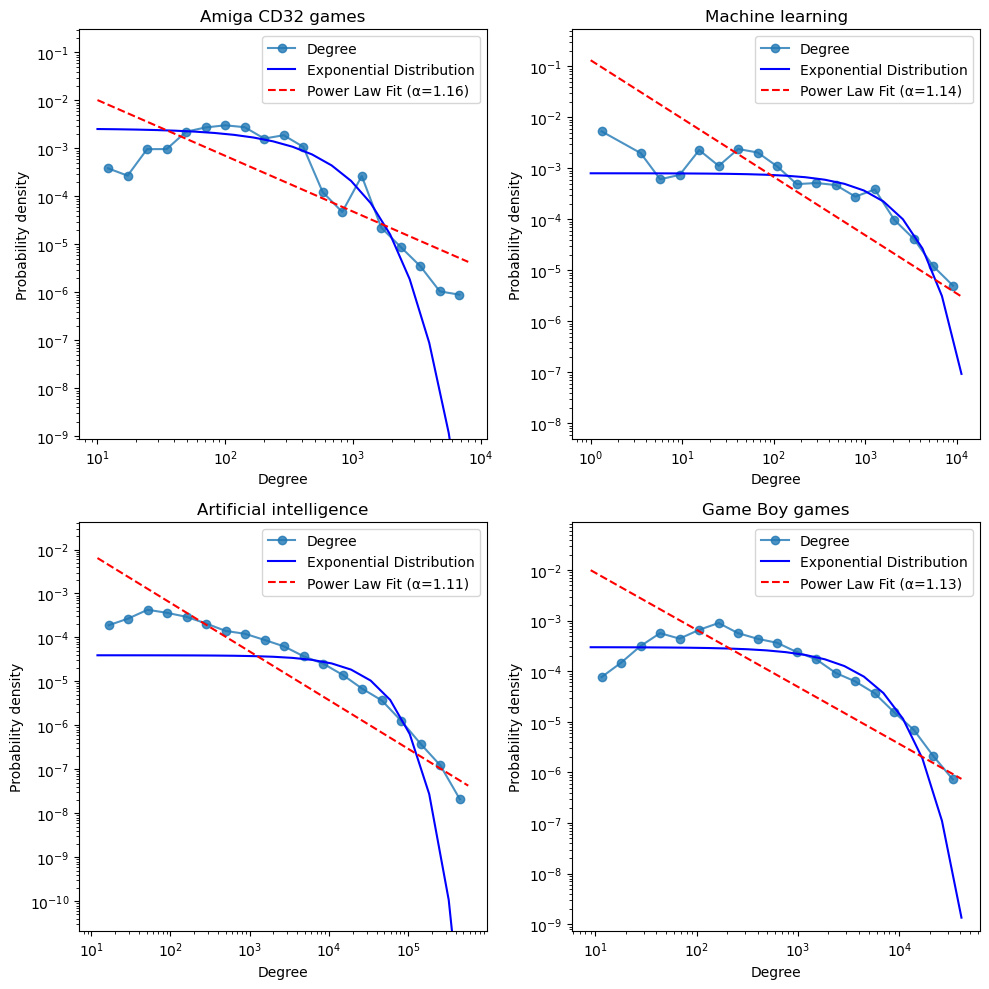

In [18]:
plot_probability_density(graph_names)

Fitting power law only above 300 degrees


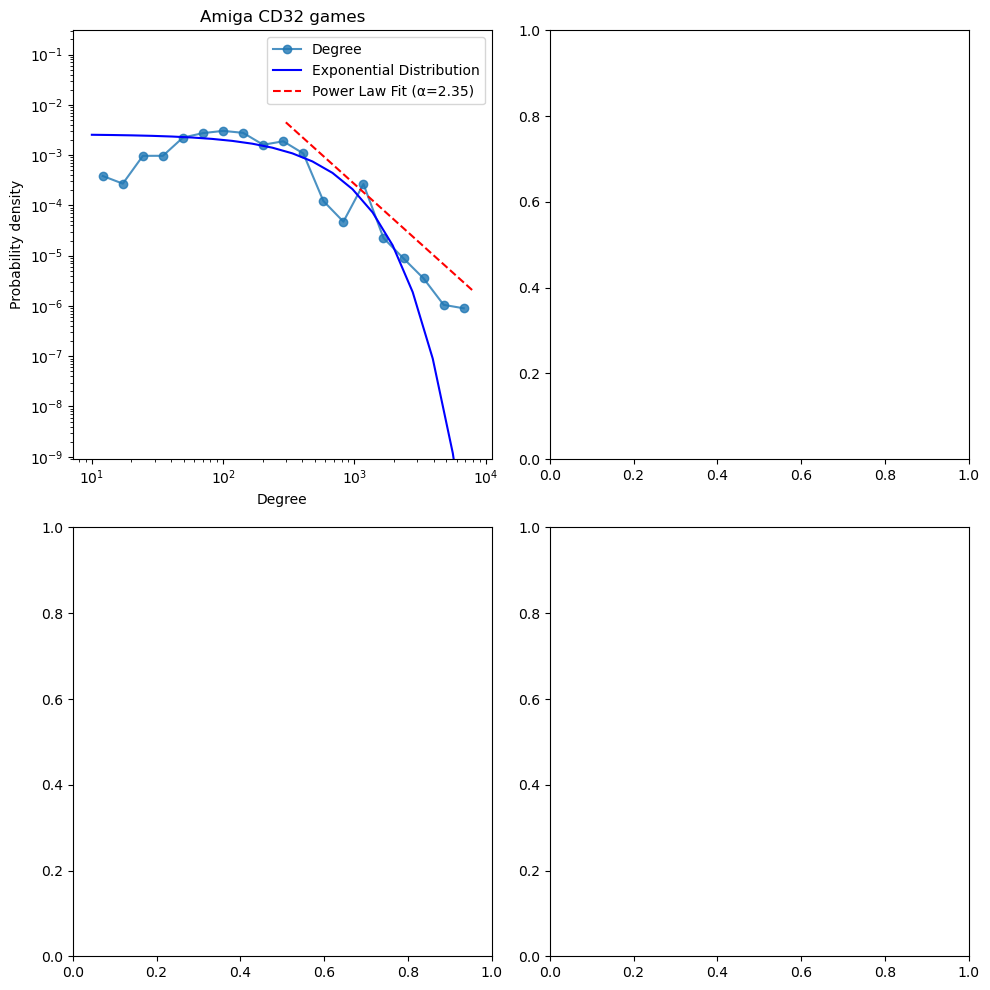

In [22]:
only_fit_above = [3*10**2, 10**2, 10**2, 10**2]
plot_probability_density(graph_names, only_fit_above=only_fit_above)